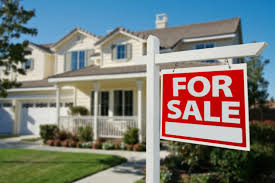

In [ ]:
import numpy as np# linear algebra
import pandas as pd 
import seaborn as sns
import sklearn
import warnings
import io
import requests
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Acquire data to create our environment

In [ ]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

In [ ]:
train.head()

In [ ]:
data_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# Exploring data and enginner features

In [ ]:
train.SalePrice.describe()

In [ ]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='red')
plt.show()

In [ ]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.7, square=True);

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Working with numeric features

In [ ]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.dtypes

In [ ]:
# load data
train = pd.read_csv('../input/ames-housing-dataset/AmesHousing.csv')
train.drop(['PID'], axis=1, inplace=True)

origin = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
train.columns = origin.columns

test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

print('Train:{}   Test:{}'.format(train.shape,test.shape))

In [ ]:
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

In [ ]:
train.OverallQual.unique()

In [ ]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 1000)
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [ ]:
quality_pivot

In [ ]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [ ]:
plt.scatter(x=data_train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Above grade (ground) living area square feet')
plt.show()

In [ ]:
plt.scatter(x=data_train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [ ]:
# drop missing values
missing = test.isnull().sum()
missing = missing[missing>0]
train.drop(missing.index, axis=1, inplace=True)
train.drop(['Electrical'], axis=1, inplace=True)

test.dropna(axis=1, inplace=True)
test.drop(['Electrical'], axis=1, inplace=True)

# Handling null values

In [ ]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

In [ ]:
print ("Unique values are:", data_train.MiscFeature.unique())

# Wrangling non-numeric features

In [ ]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

In [ ]:
print ("Original: \n")
print (train.Street.value_counts(), "\n")

In [ ]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)

In [ ]:
print ('Encoded: \n')
print (train.enc_street.value_counts())

In [ ]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [ ]:
def encode(x):
 return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

In [ ]:
condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [ ]:
from tqdm import tqdm
l_data_test = tqdm(range(0, len(data_test)), desc='Matching')
for i in l_data_test:
    for j in range(0, len(data_train)):
        for k in range(1, len(data_test.columns)):
            if data_test.iloc[i,k] == data_train.iloc[j,k]:
                continue
            else:
                break
        else:
            submission.iloc[i, 1] = data_train.iloc[j, -1]
            break
l_data_test.close()

In [ ]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [ ]:
sum(data.isnull().sum() != 0)

# Modeling

In [ ]:
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [ ]:
model = lr.fit(X_train, y_train)

In [ ]:
print ("R^2 is: \n", model.score(X_test, y_test))

In [ ]:
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

In [ ]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [ ]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

# Making a submission

In [ ]:
#submission.to_csv('house-predict-sub.csv', index=False)

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [ ]:
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()

In [ ]:
predictions = model.predict(feats)

In [ ]:
final_predictions = np.exp(predictions)

In [ ]:
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

In [ ]:
submission['SalePrice'] = final_predictions
submission.head()

In [ ]:
submission.to_csv('submission1.csv', index=False)

# If you like this notebook, please give an Upvote! Don't forget to check out my other notebooks too!

* [ConnectX Baseline](https://www.kaggle.com/brendan45774/connectx-baseline)
* [Countries Life Expectancy Animation](https://www.kaggle.com/brendan45774/countries-life-expectancy-animation)
* [Data Visuals - Matplotlib](http://www.kaggle.com/brendan45774/data-visuals-matplotlib)
* [Digit Recognizer Solution](http://www.kaggle.com/brendan45774/digit-recognizer-solution)
* [Dictionary and Pandas Cheat sheet](https://www.kaggle.com/brendan45774/dictionary-and-pandas-cheat-sheet)
* [EDA Tutorial Hollywood Movies](https://www.kaggle.com/brendan45774/eda-tutorial-hollywood-movies)
* [Getting started with Matplotlib](http://www.kaggle.com/brendan45774/getting-started-with-matplotlib)
* [HOG features - Histogram of Oriented Gradients](https://www.kaggle.com/brendan45774/hog-features-histogram-of-oriented-gradients)
* [How to get the lowest score](https://www.kaggle.com/brendan45774/how-to-get-the-lowest-score)
* [House predict solution](http://www.kaggle.com/brendan45774/house-predict-solution)
* [K-Means Clustering (Image Compression)](https://www.kaggle.com/brendan45774/k-means-clustering-image-compression)
* [Kuzushiji-MNIST Panda](http://www.kaggle.com/brendan45774/kuzushiji-mnist-panda)
* [Plotly Coronavirus (Covid-19)](https://www.kaggle.com/brendan45774/plotly-coronavirus-covid-19)
* [Titanic Top Solution](http://www.kaggle.com/brendan45774/titanic-top-solution)
* [Titanic Data Solution](http://www.kaggle.com/brendan45774/titanic-data-solution)
* [Word Cloud - Analyzing Names](https://www.kaggle.com/brendan45774/word-cloud-analyzing-names)